# Breast Cancer Detection Model


    The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

* **Database**:
<div class="alert alert-block alert-success">
    <i>Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief.2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.</i>
</div>
<br>
* Validation Scores for Classification Model:
    <ul>
    <li><b>Accuracy</b>: <i>89.74 %</i></li>
    <li><b>Precision</b>: <i>90.1%</i></li>
    <li><b>Recall</b>**: <i>89.74%</i></li>
    <li><b>**F1**</b>: <i>89.80%</i></li>
    </ul>
<br>
* Validation Scores for Segmentation Model:

<ul>
    <li><b>IoU</b>: <i>75.32%</i></li>
</ul>

#### Load libraries

In [1]:
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
from tensorflow.keras import backend
from raunet.utils.helper_loss_functions import jaccard_loss_function
from raunet.utils.helper_metric_functions import make_confusion_matrix
from raunet.utils.helper_metric_functions import calculate_results
from raunet.utils.load_and_visualize_data import loadData, show_images
from raunet.utils.load_and_visualize_data import preprocess_classification_data
from raunet.tools.visualizations import visualize_predictions, visualize_random_samples
from raunet.utils.load_and_visualize_data import visualize_segmentation_and_classification
from tensorflow.keras.utils import to_categorical
from raunet.config import hyperparameters

2025-12-03 22:06:38.581607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 22:06:38.701244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-03 22:06:38.701258: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-12-03 22:06:39.436304: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-

Segmentation Models: using `tf.keras` framework.


### Hyperparameters

In [2]:
hyperparameters

{'batch_size': 32,
 'num_filters': 16,
 'filter_multiplier': [4, 4, 8, 16],
 'dropout': 0.2,
 'batch_norm': True,
 'kernel_size': 3,
 'epochs': 500,
 'learning_rate': 0.001,
 'loss_func': <function raunet.utils.helper_loss_functions.jaccard_loss_function(y_true, y_pred)>,
 'size': 128,
 'shape': (128, 128, 1)}

### EDA

In [3]:
root_path = Path("../.data")

classes = [x.name for x in root_path.iterdir() if x.is_dir()]
classes

['benign', 'normal', 'malignant']

In [4]:
total_number_of_classes = {}
for single_class in classes:
    total_number_of_classes[single_class] = len(sorted(root_path.glob(f"{single_class}/*.png")))
total_number_of_classes

{'benign': 891, 'normal': 266, 'malignant': 421}

#### Conlusions:
* We have highly unbalanced dataset, however the data show enough variation that this should not be a problem

### Load and preprocess data

In [5]:
train_data, test_data, X_train, X_test, y_train, y_test = loadData(path=root_path, files=True, batch_size=hyperparameters['batch_size'], size=hyperparameters['size'], split=0.10)

Used memory to store the float image dataset is:  48.75
Used memory to store the float mask dataset is:  48.75


2025-12-03 22:07:00.027646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-12-03 22:07:00.030929: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacob/miniconda3/envs/my_env/lib/python3.10/site-packages/cv2/../../lib64:
2025-12-03 22:07:00.030980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacob/miniconda3/envs/my_env/lib/python3.10/site-packages/cv2/../../lib64:
2025-12-03 22:07:00.031022: W tensorflow/compiler/xla/stream_executor/platform/default/

In [6]:
(X_train.min(), X_train.max(), X_test.min(), X_test.max()), (y_train.min(), y_train.max(), y_test.min(), y_test.max())

((0.0, 1.0, 0.0, 1.0), (0.0, 1.0, 0.0, 1.0))

### Visualizations

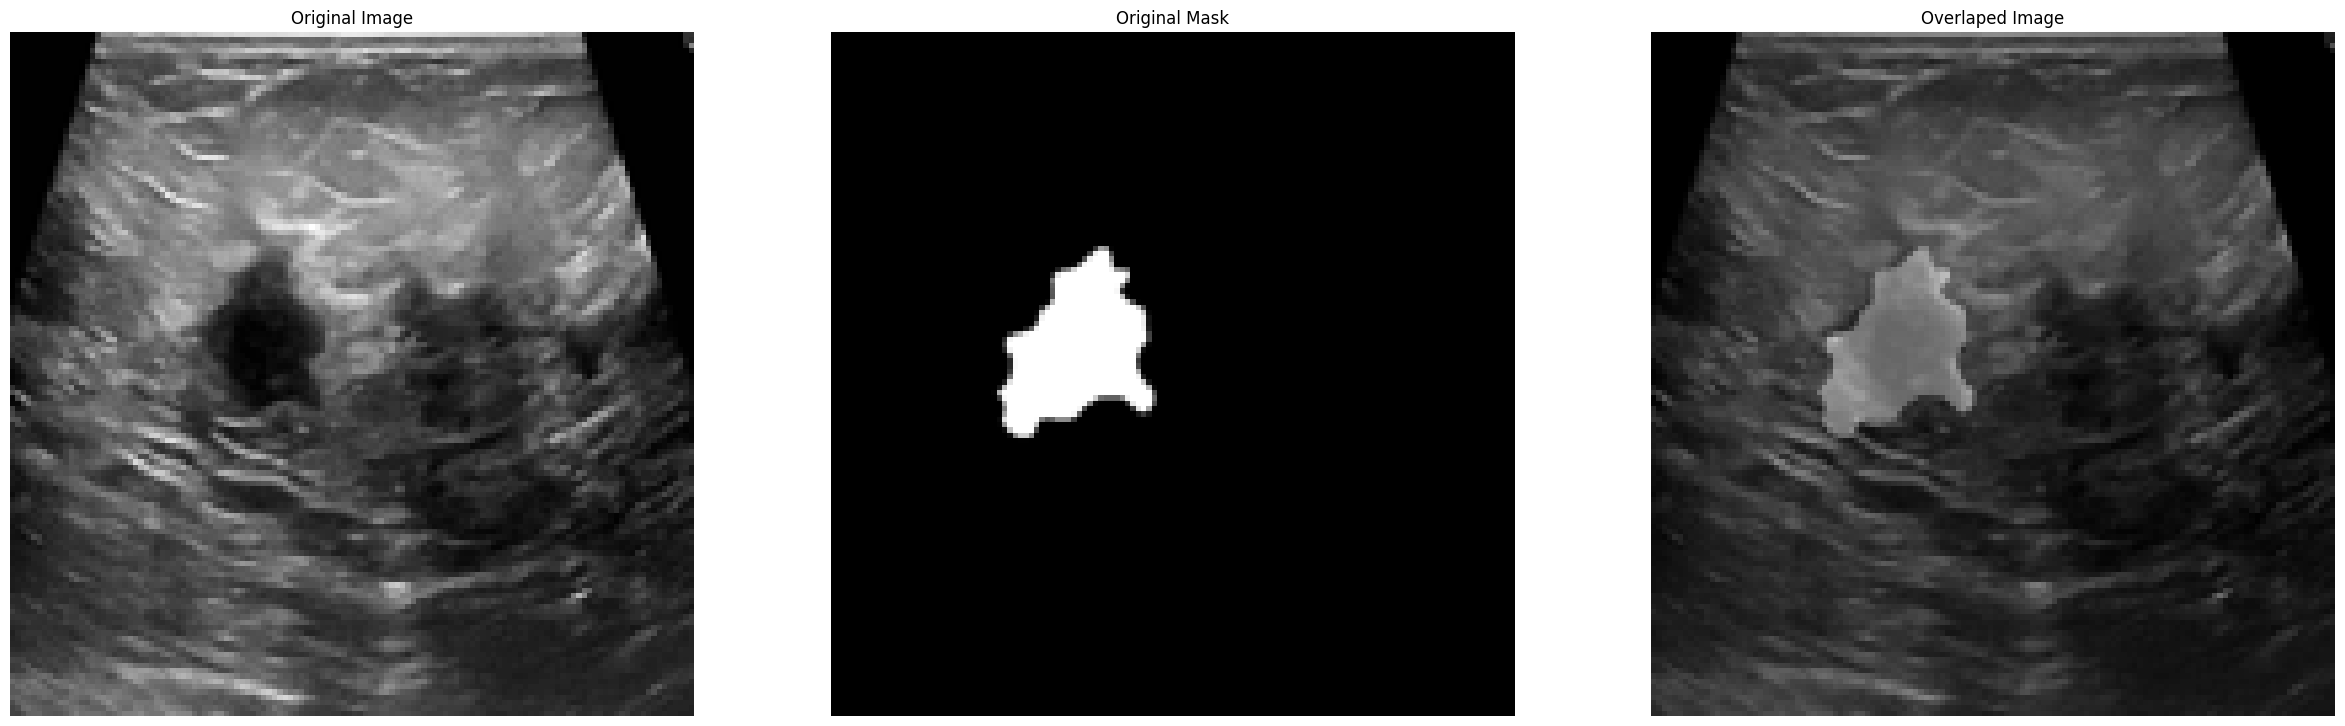

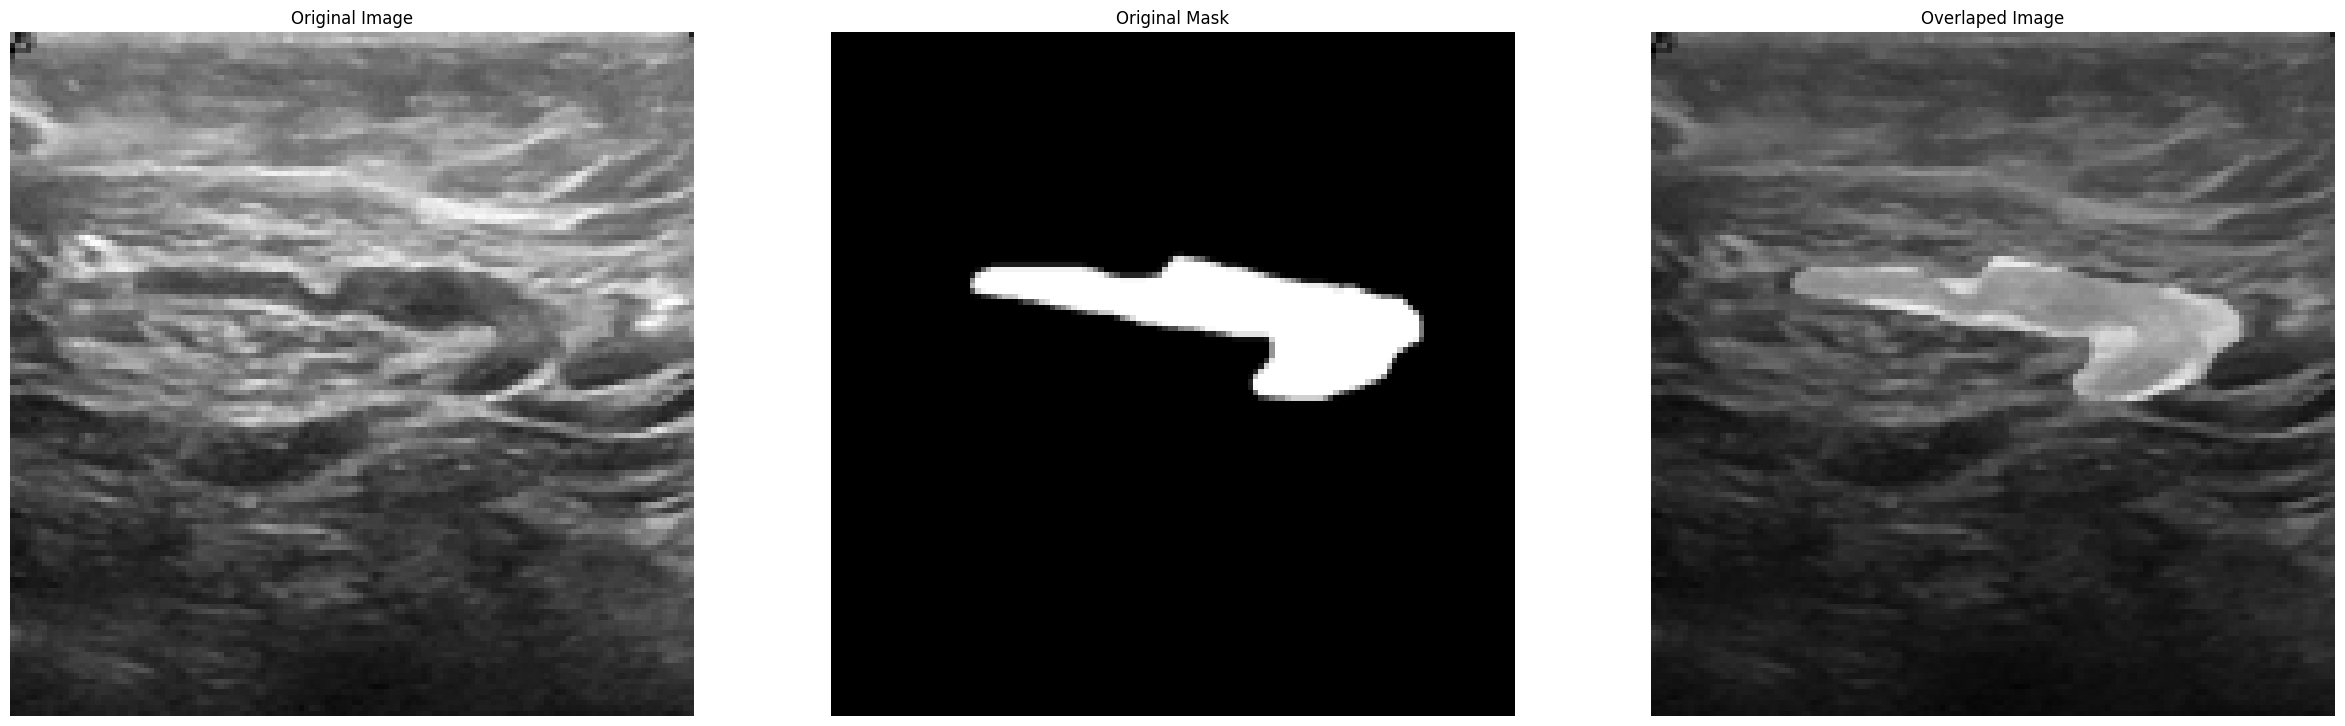

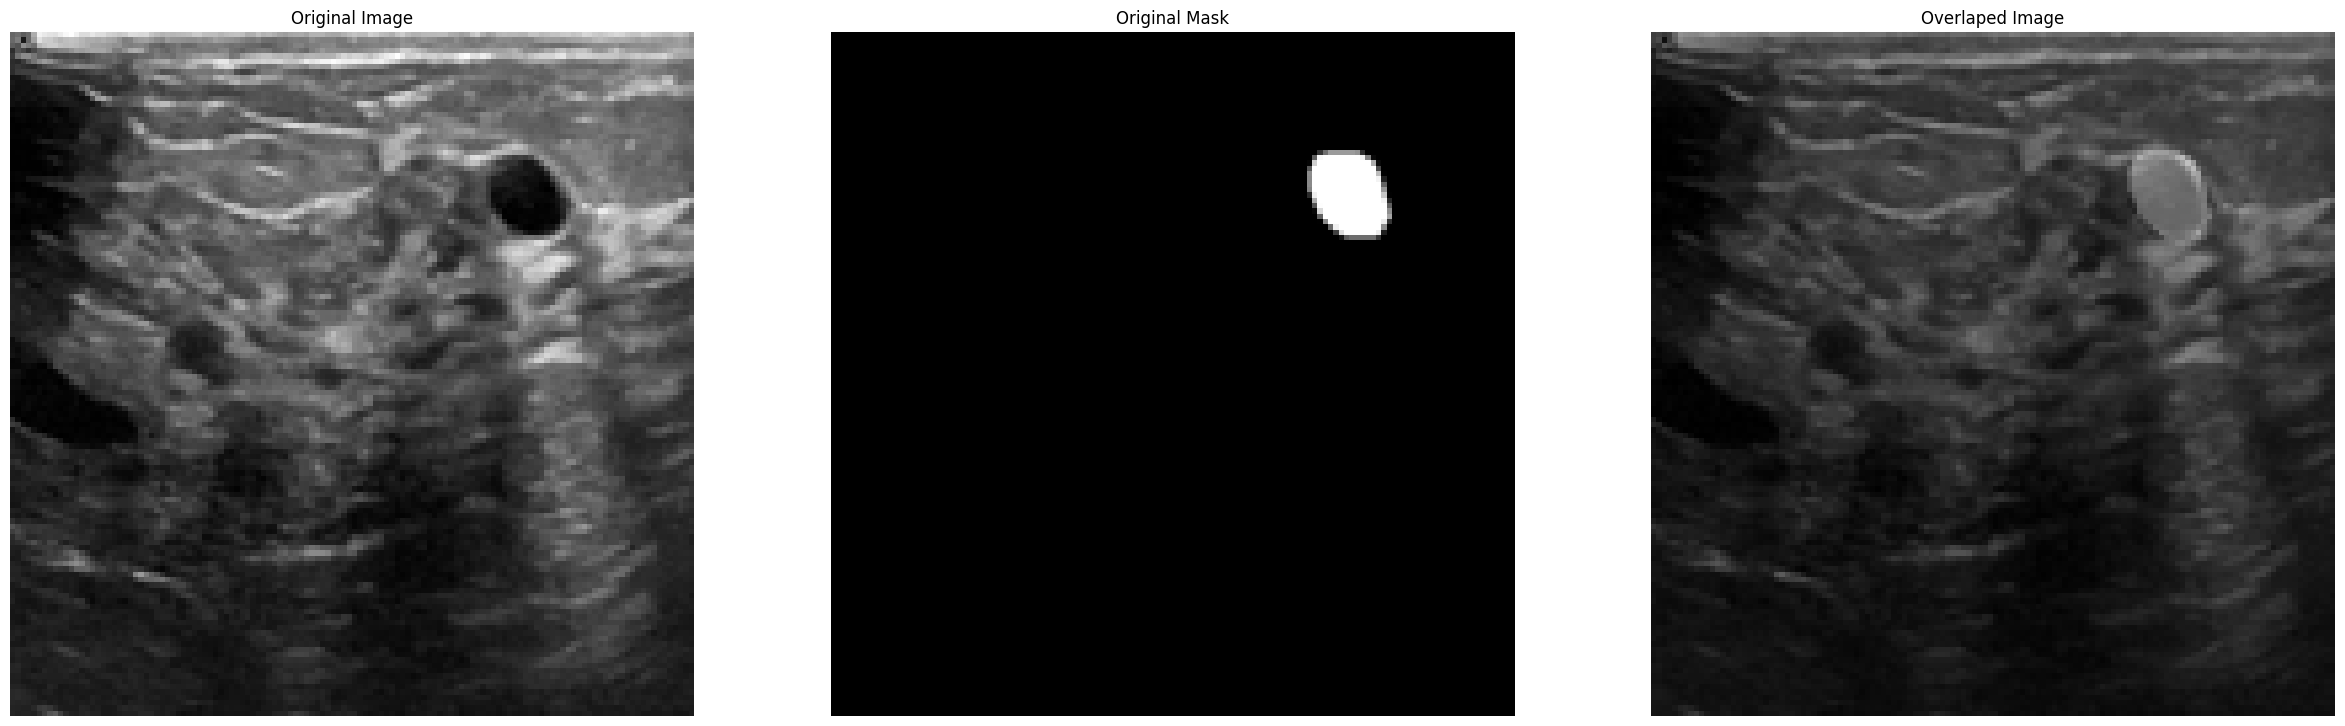

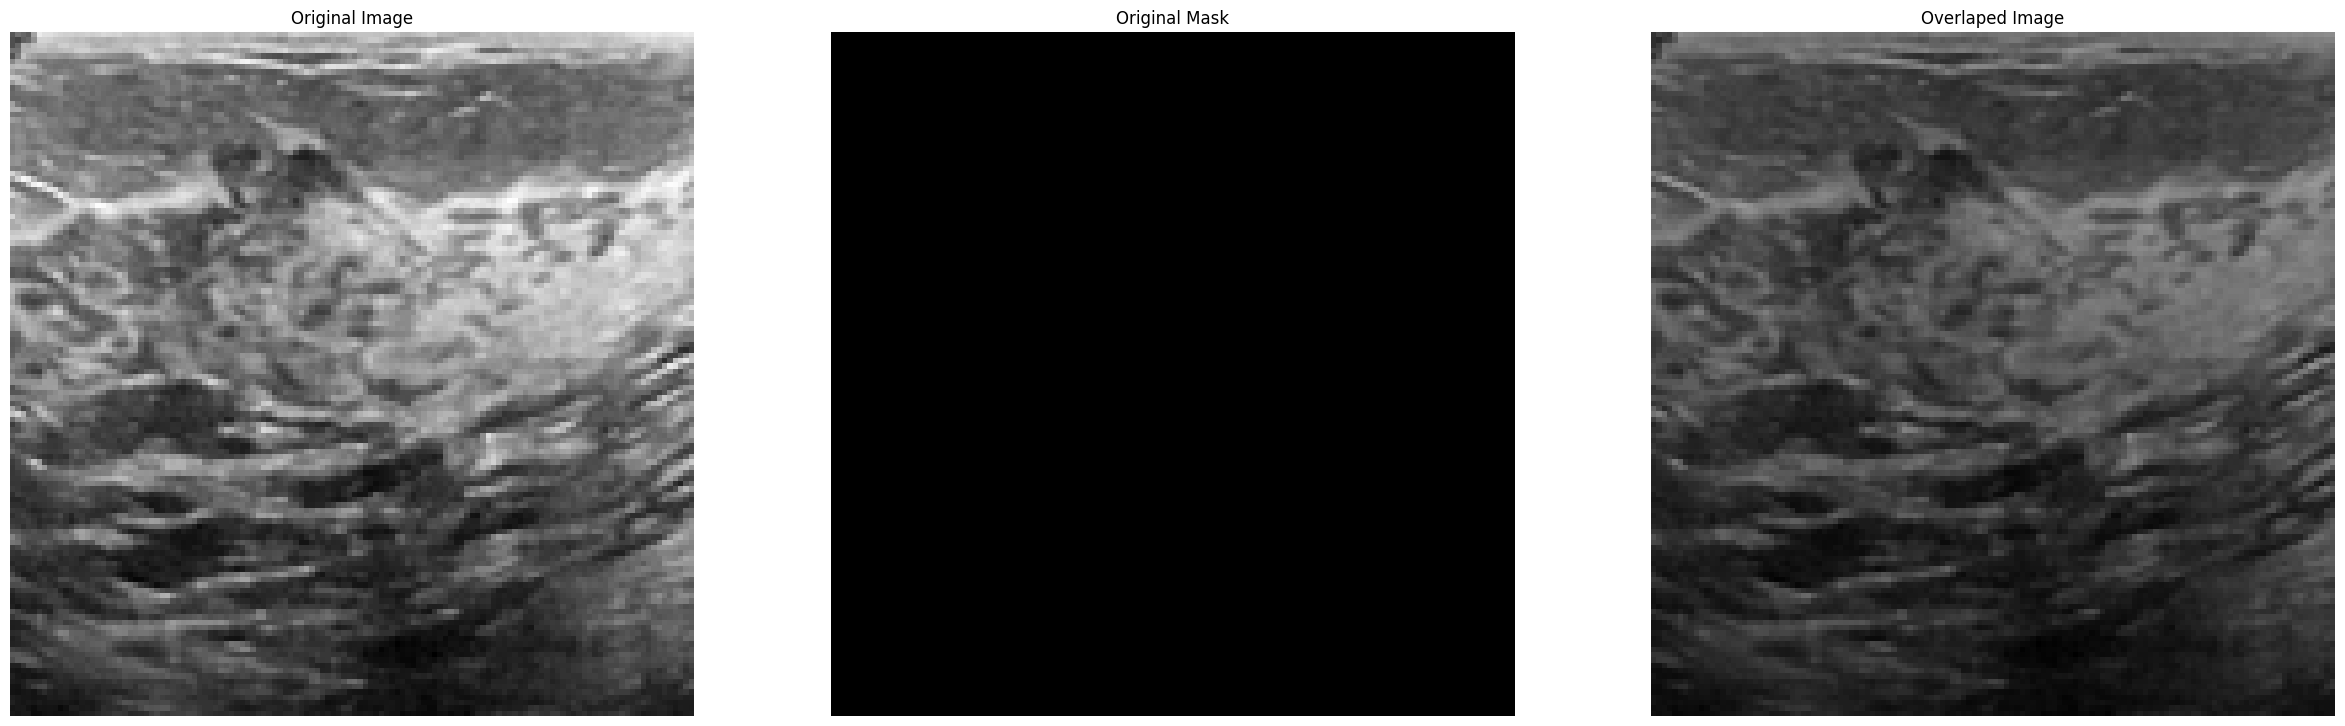

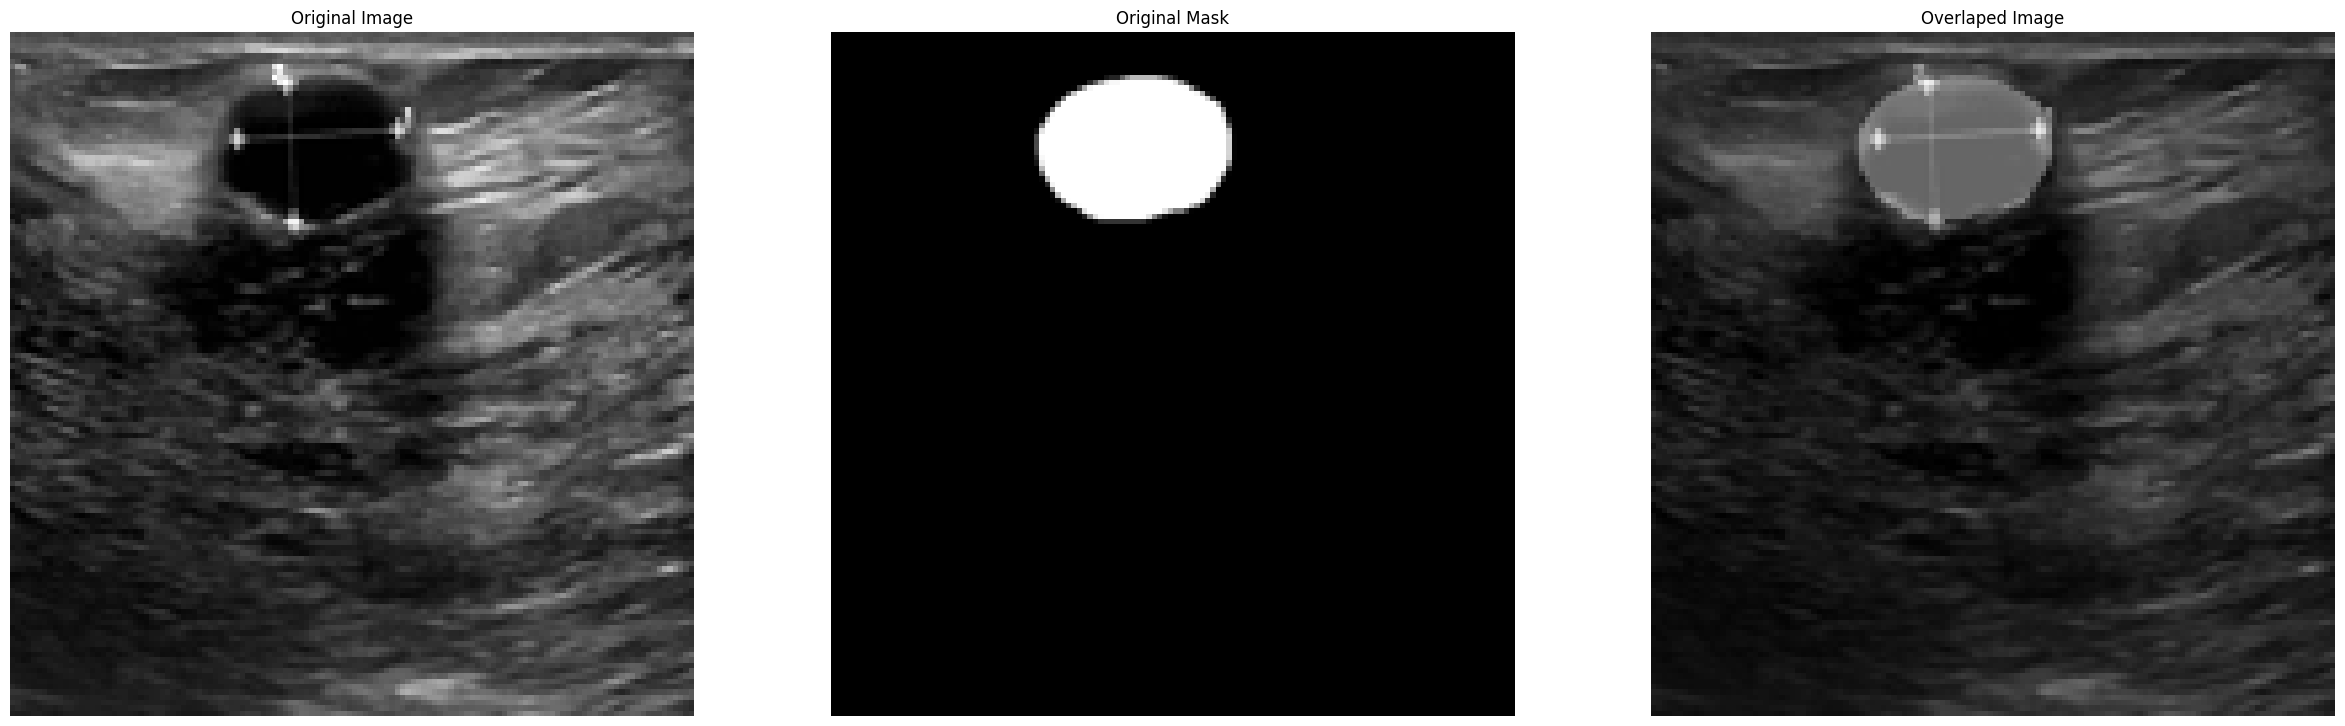

In [7]:
show_images(train_data)

In [8]:
attemption_residual_unet = tf.keras.models.load_model("../model/Attention_Residual_Unet_29_excel.h5", custom_objects={
    "K": backend,
    "jaccard_loss_function": jaccard_loss_function,
    "iou_score" : sm.metrics.IOUScore(threshold=0.5)
})

/home/jacob/miniconda3/envs/my_env/lib/python3.10/site-packages/keras/layers/core/lambda_layer.py:324: UserWarning: models_to_test is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(


### Check Results

* 1st column - Real Images
* 2st column - Images segmentated by Radiologists
* 3st column - Model Predictions
* 4st column - Overlapped image and model prediction
* 5st column - Places to which the model pays special attention

1/1 [==============================] - 1s 594ms/step


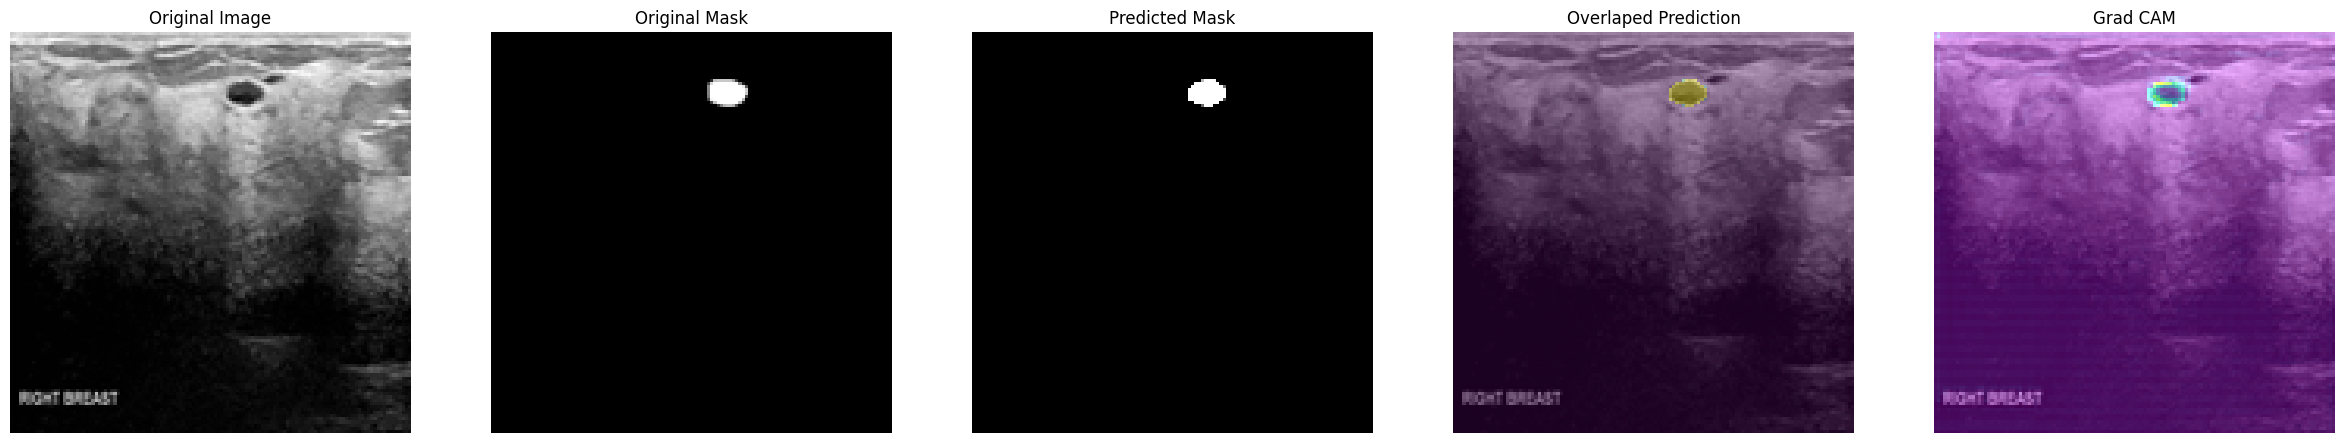

1/1 [==============================] - 0s 36ms/step


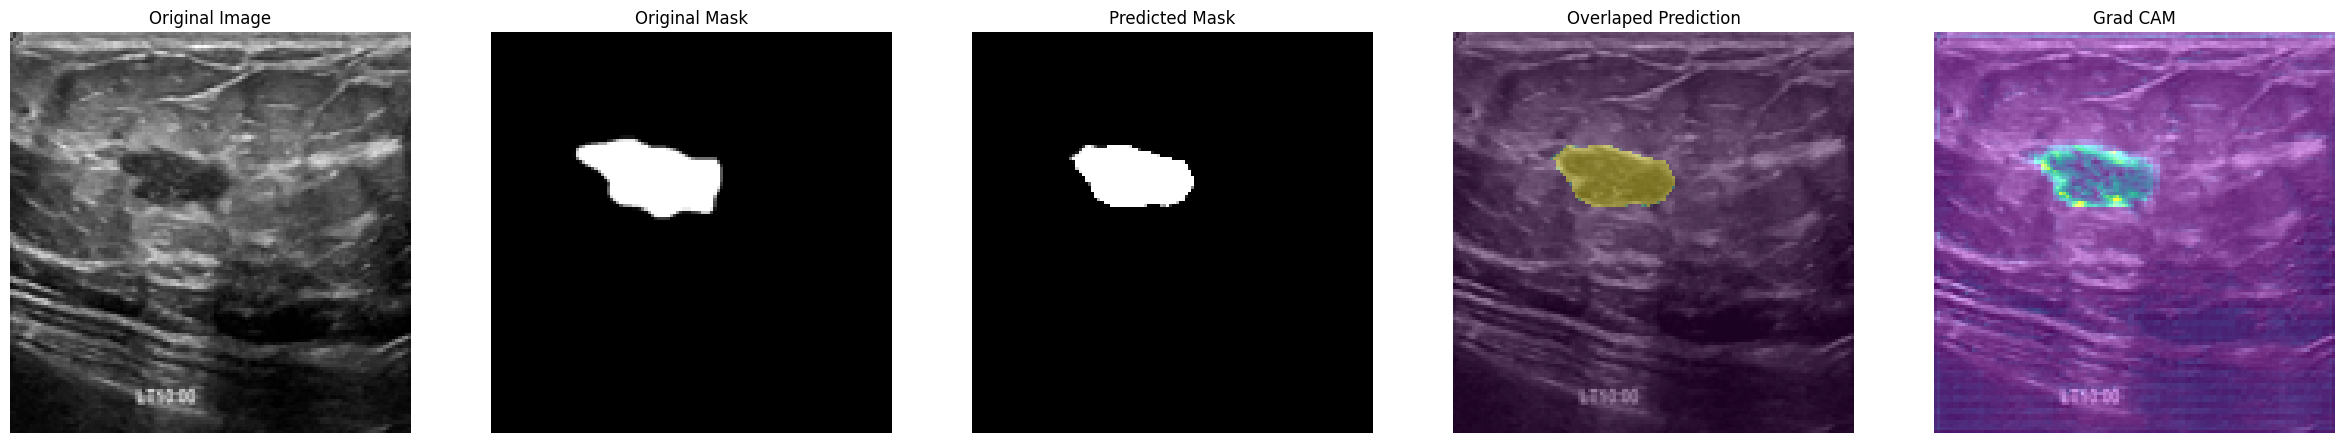

1/1 [==============================] - 0s 32ms/step


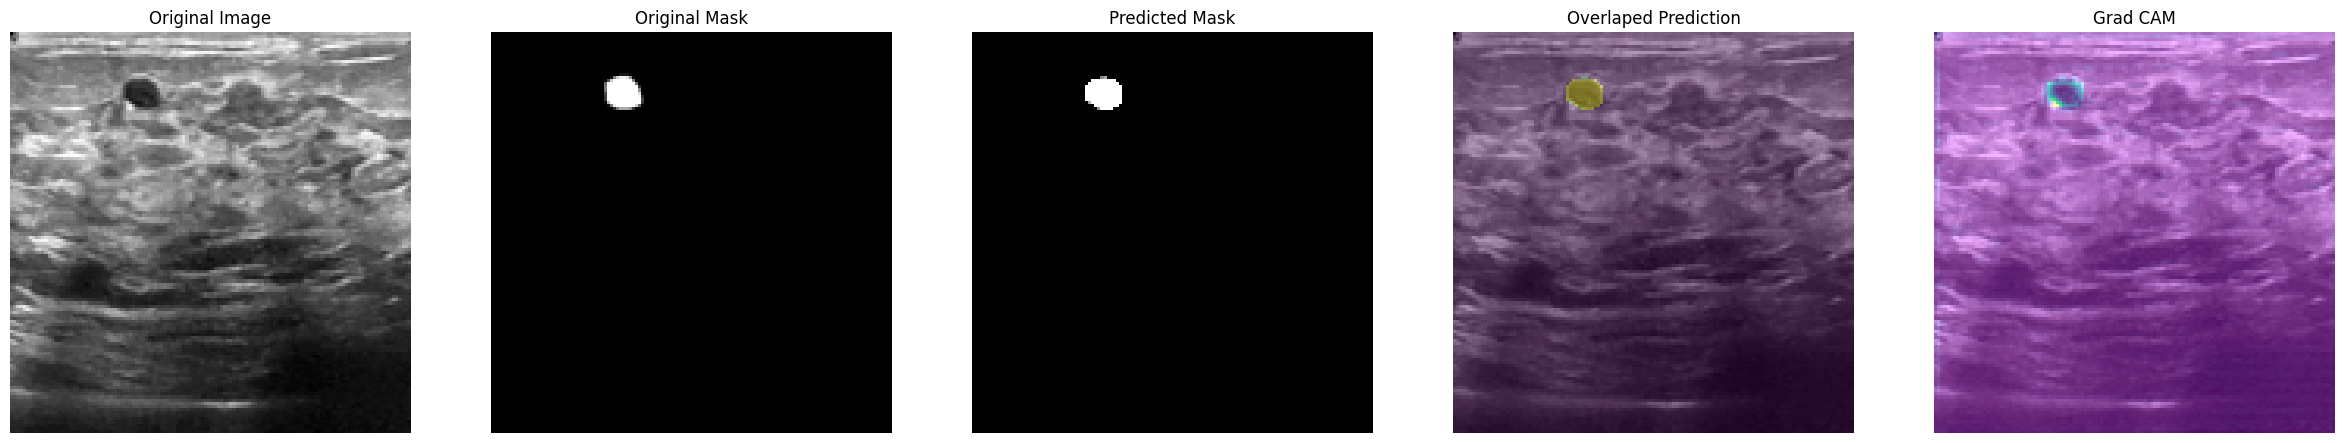

1/1 [==============================] - 0s 32ms/step


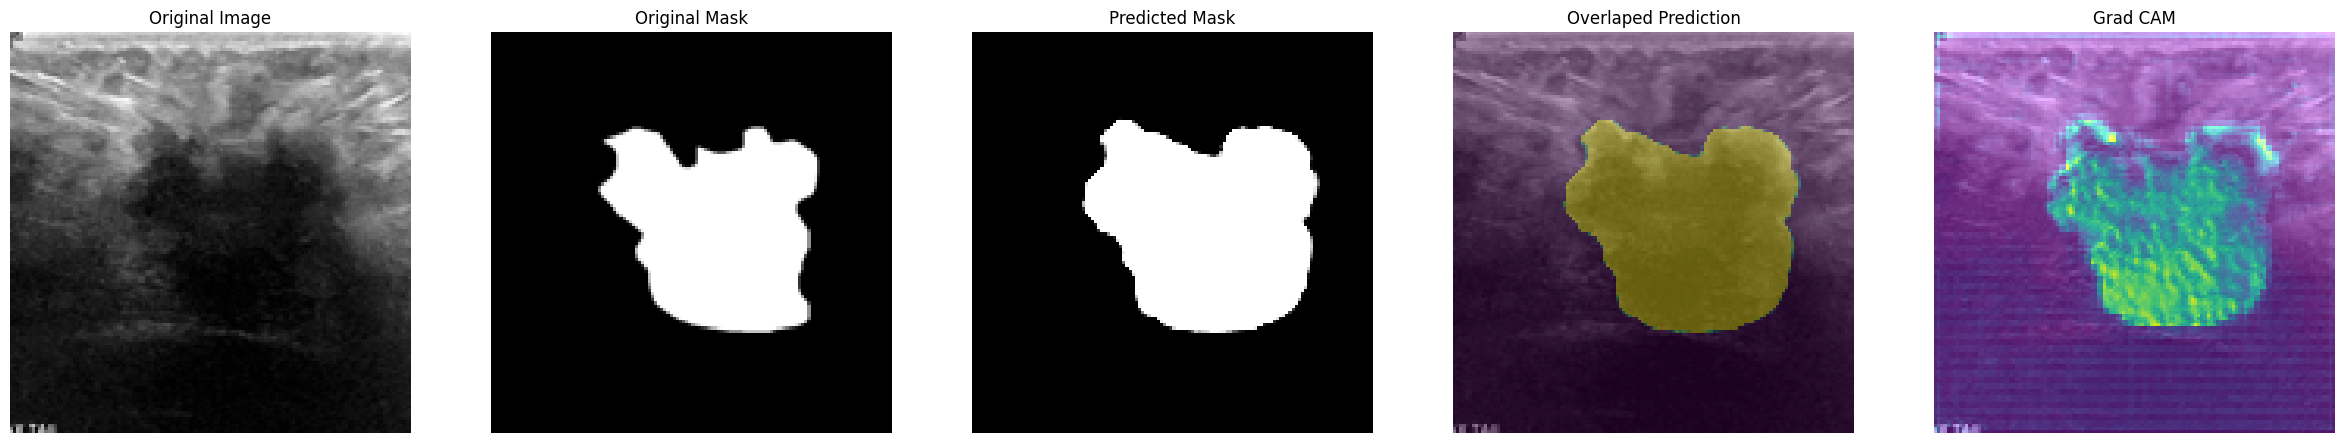

1/1 [==============================] - 0s 37ms/step


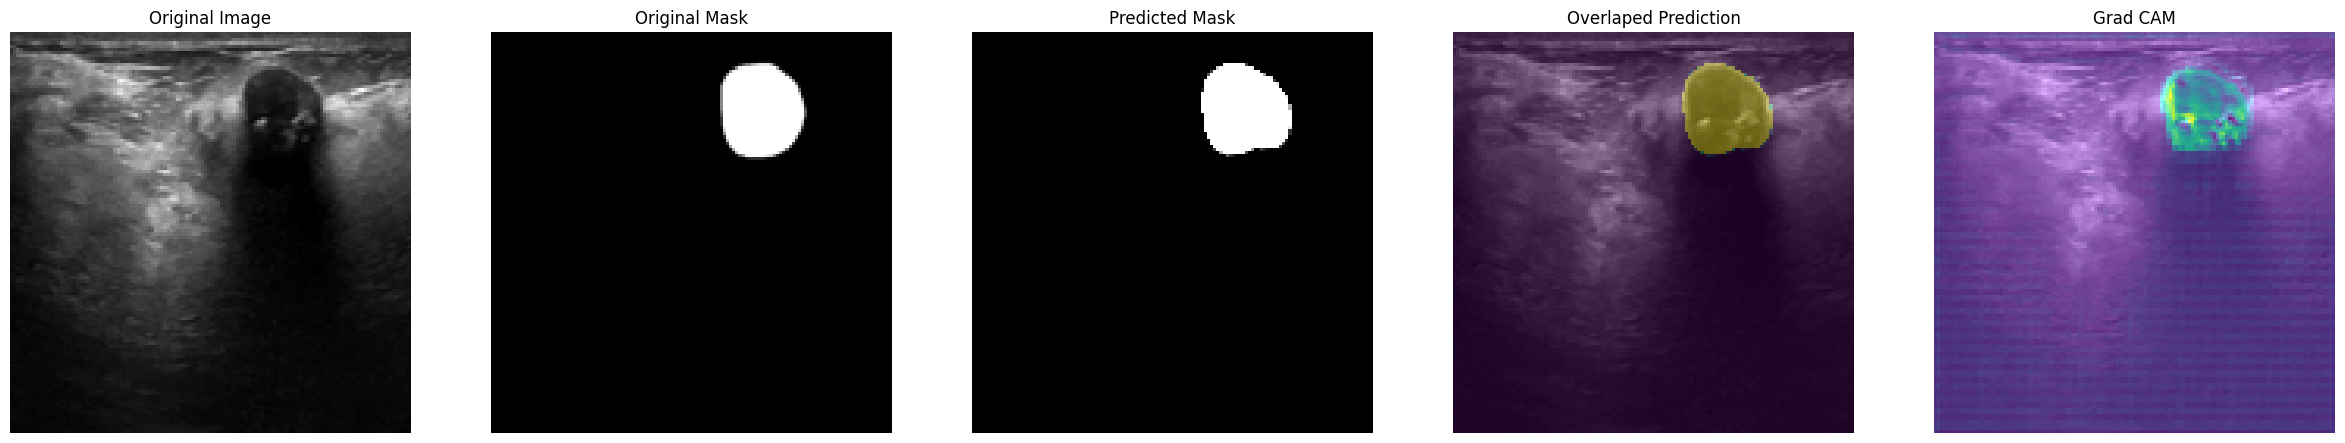

In [9]:
show_images(train_data, model=attemption_residual_unet, explain=True)

In [10]:
y_pred = attemption_residual_unet.predict(X_test) > 0.6

3/3 [==============================] - 1s 304ms/step


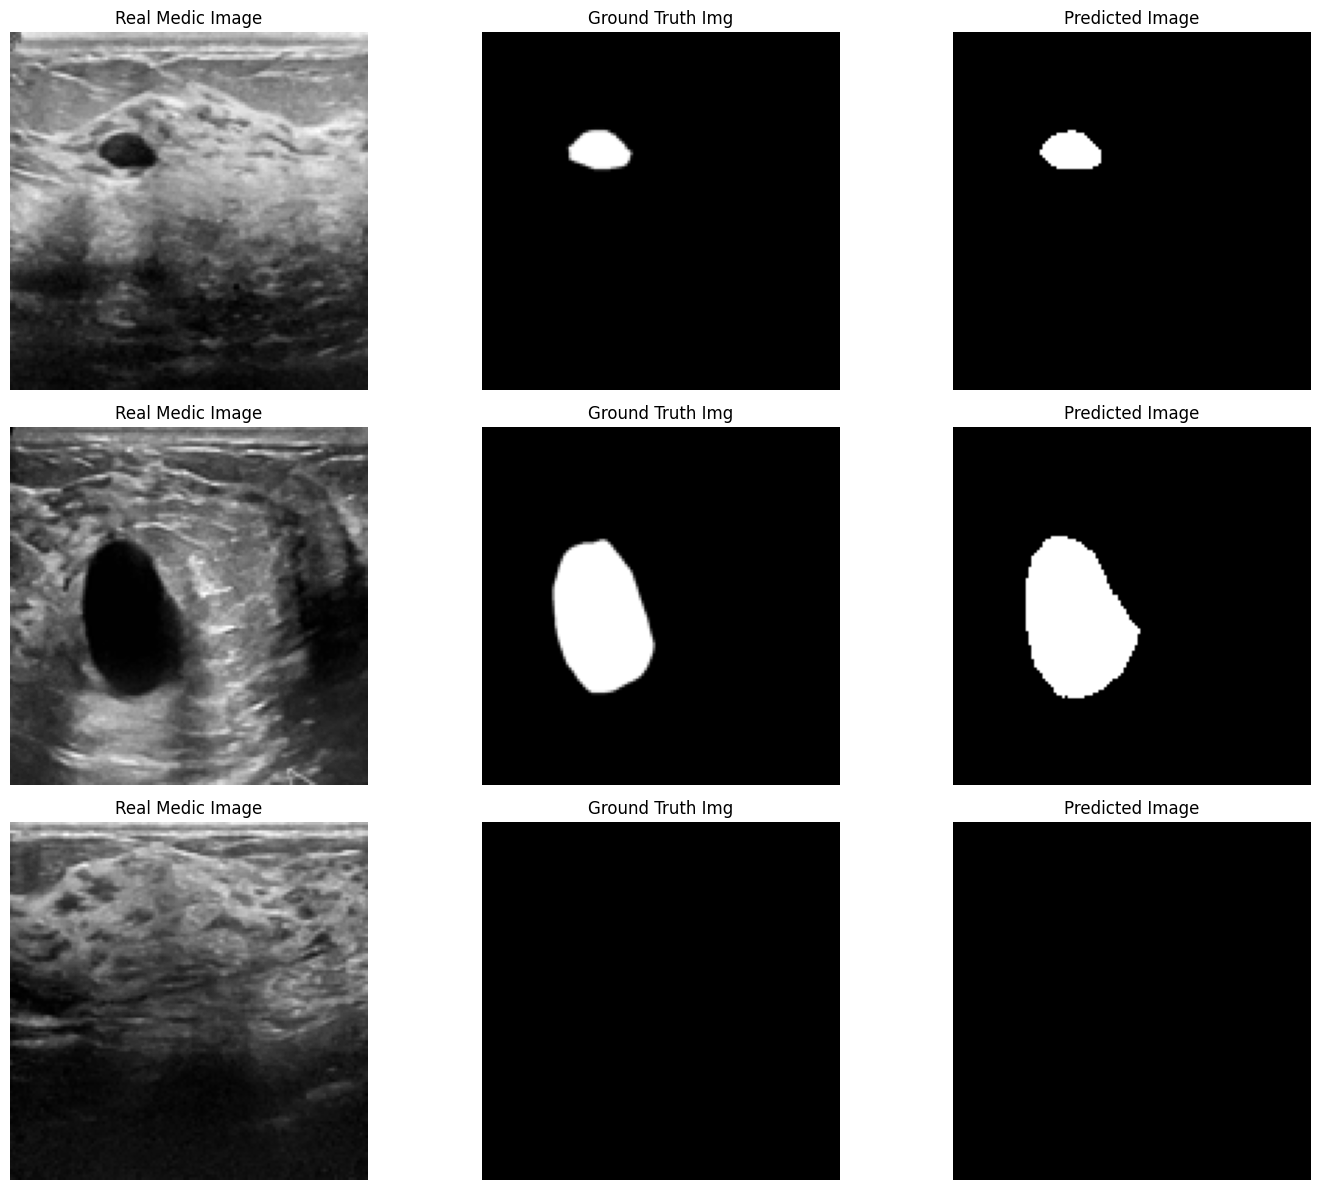

In [11]:
visualize_predictions(X_test, y_test, y_pred, num_samples=3)

### Load and preprocess data for classification part

In [12]:
images, masks, labels, paths = loadData(root_path, classification_problem=True, size=128)

In [13]:
train_gen, X_train_c, X_test_c, y_train_c, y_test_c = preprocess_classification_data(images, labels)

In [14]:
info = [
    'benign'   ,  # 0
    'malignant'   ,  # 1
    'normal',  # 2
]

### Analyze and visualize the data

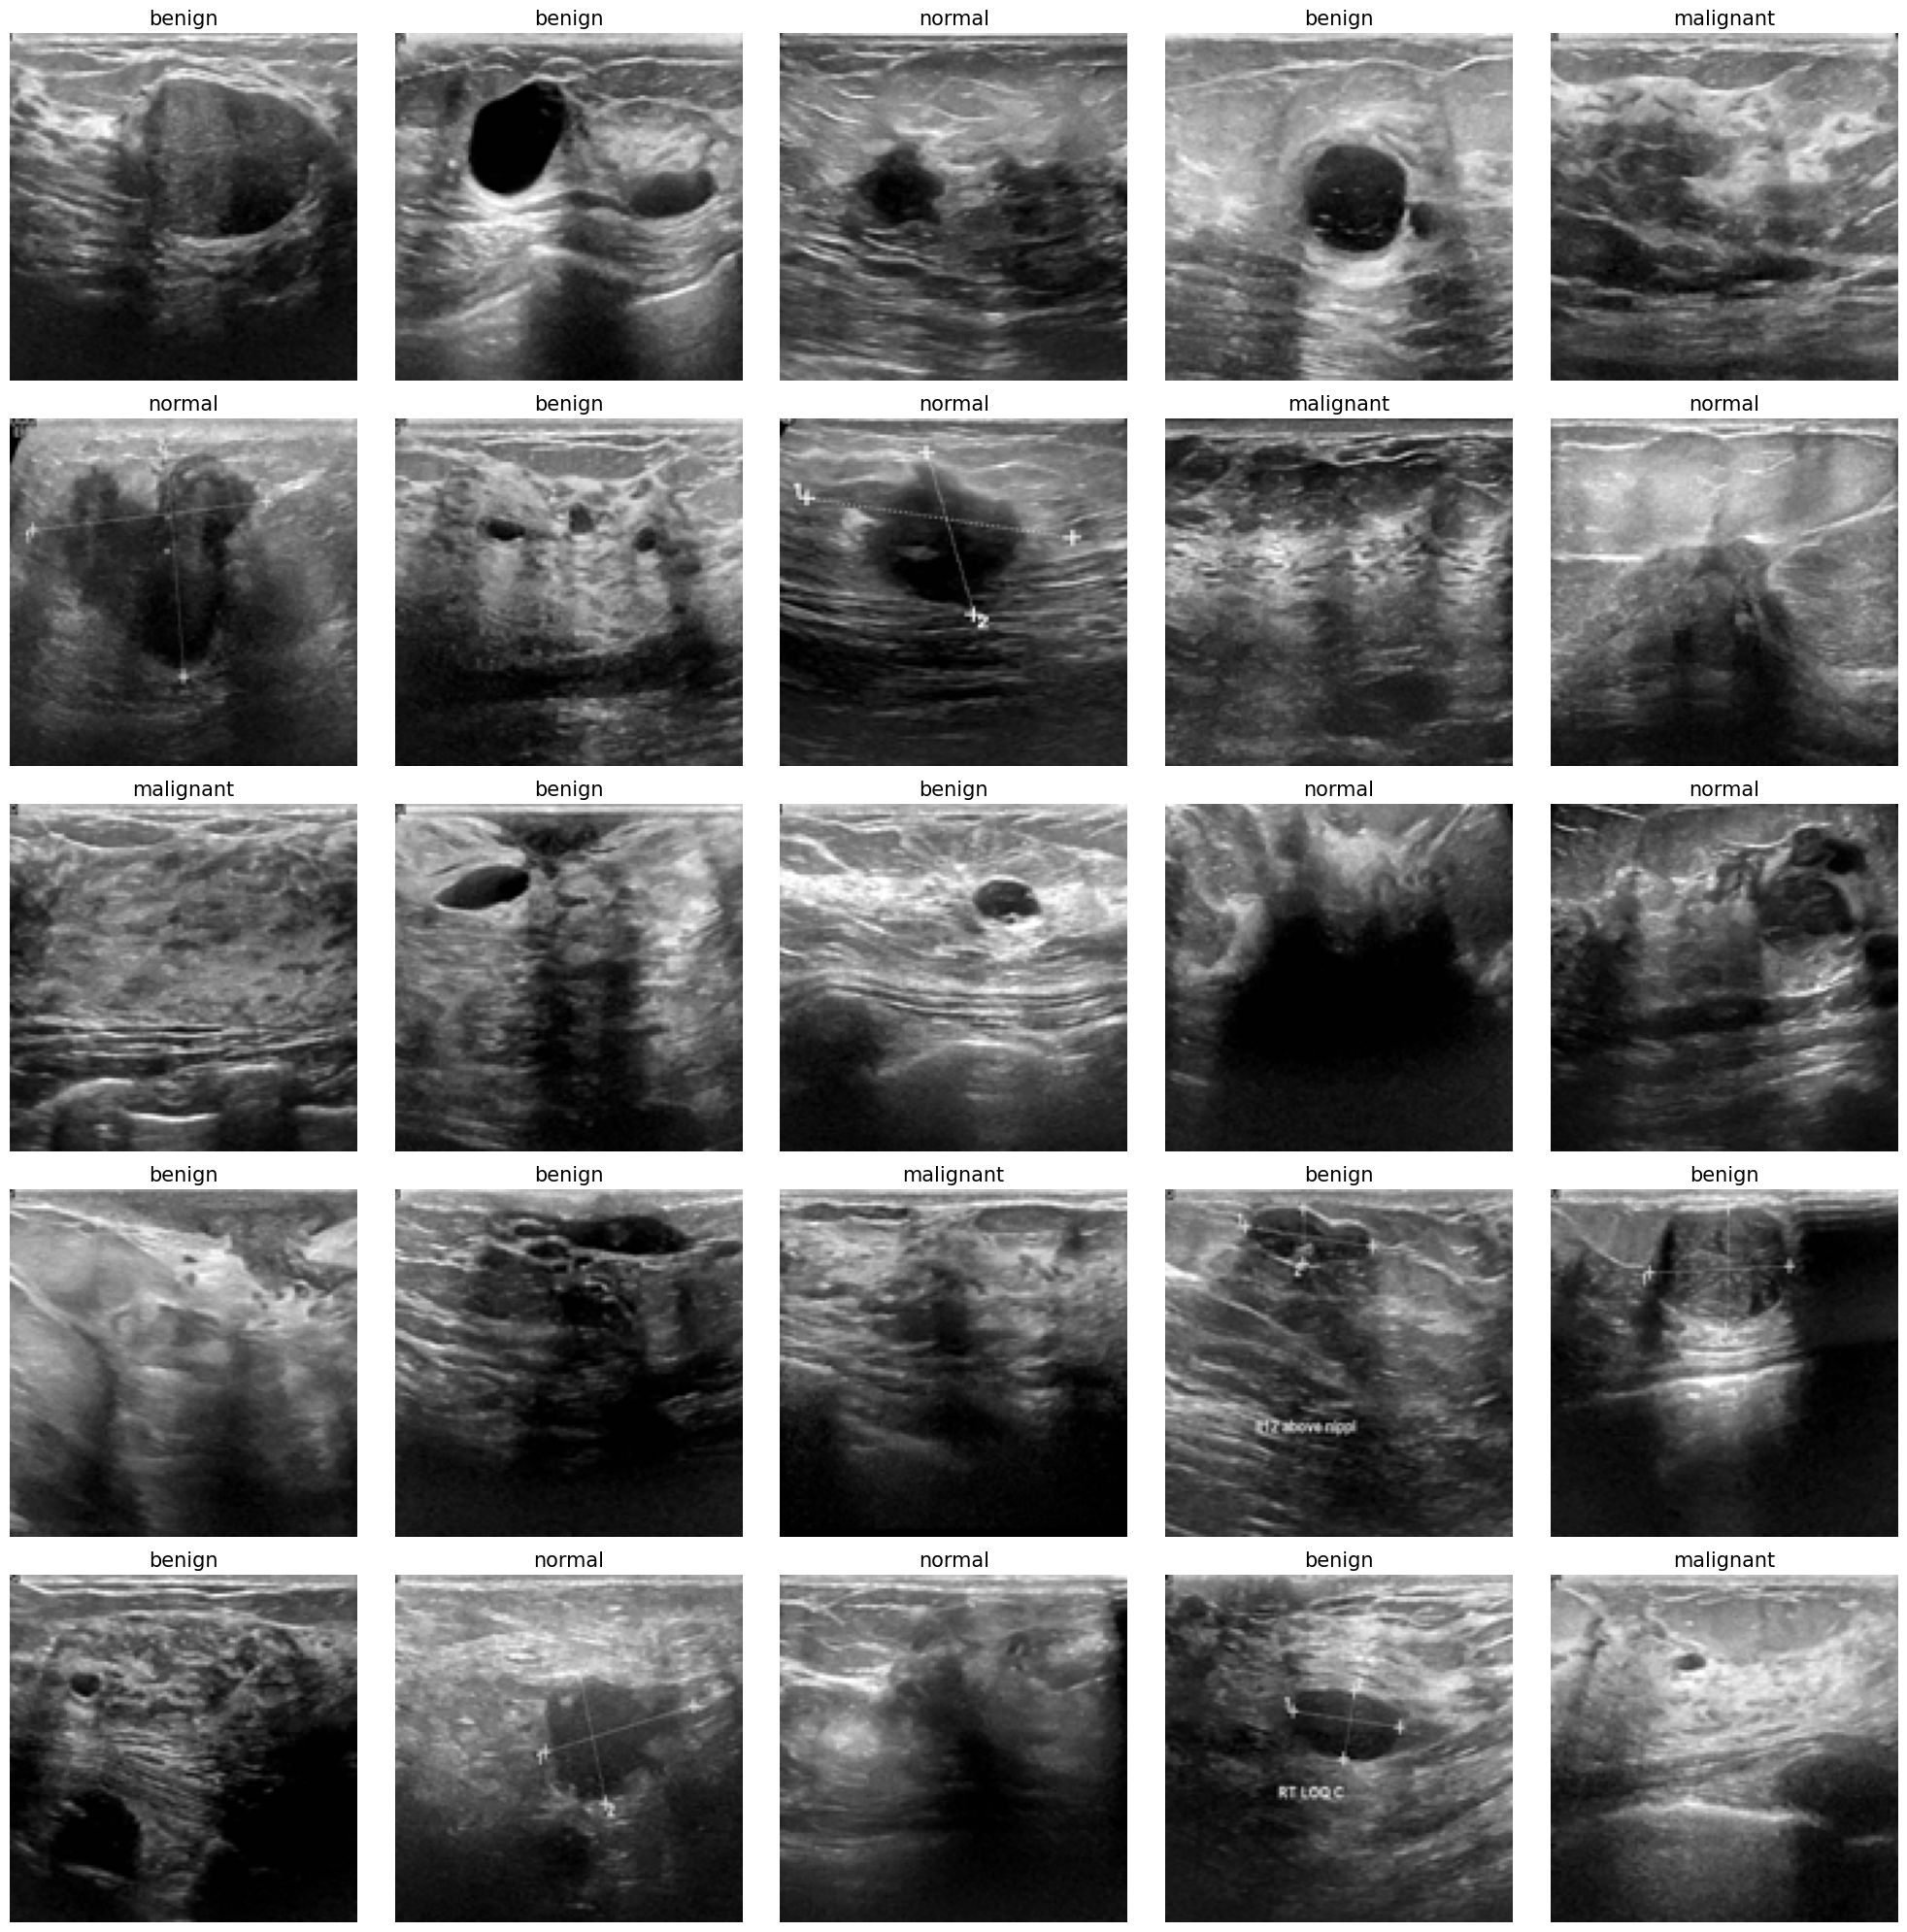

In [15]:
visualize_random_samples(X_train_c, y_train_c, classes)

In [16]:
classification_model = tf.keras.models.load_model("../model/classification_model_images.h5")

### Evaluate classification model

In [17]:
labels = np.array(labels)
labels = to_categorical(labels)

In [18]:
y_pred = classification_model.predict(images)

25/25 [==============================] - 8s 316ms/step


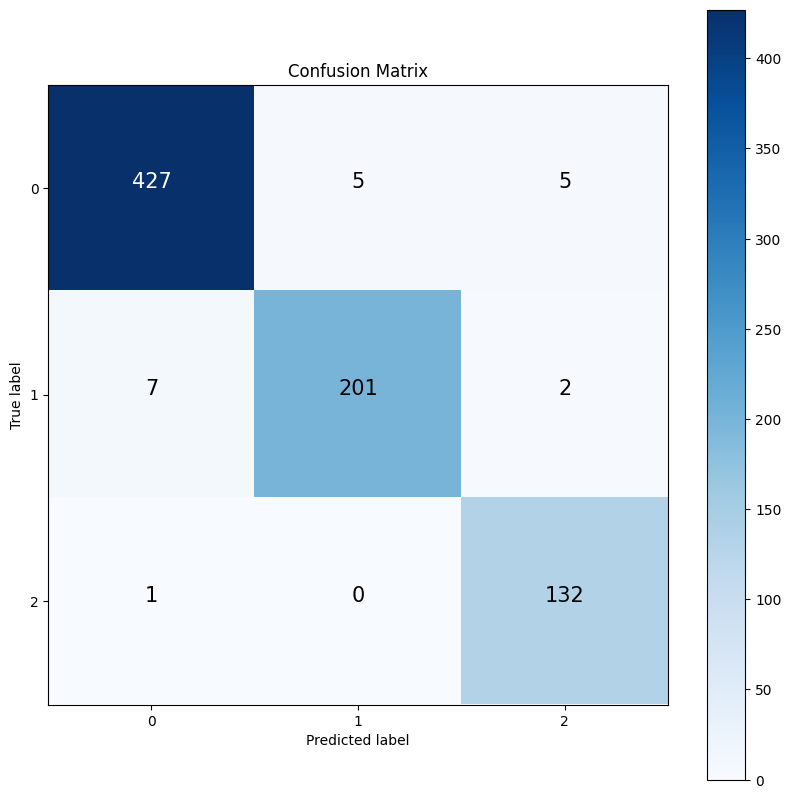

In [19]:
make_confusion_matrix(labels, y_pred)

In [20]:
calculate_results(labels, y_pred)

{'accuracy': 97.43589743589743,
 'precision': 97.4574729853263,
 'recall': 97.43589743589743,
 'f1': 97.43593402563782,
 'MCC': 0.9563264173114717,
 'kappa': 0.9562483523017293}

# Finish... Full models evaluation
* 1st column - Real Images
* 2st column - Images segmentated and labeled by Radiologists
* 3st column - Model Predictions (Predicted label and masks)
* 4st column - Overlapped image and model prediction
* 5st column - Places to which the model pays special attention

<div class="alert alert-block alert-danger">
<b>Attention</b>: Both model and label are predicted by two separate models. If the label does not match the mask, it means that you need to pay special attention to this image.
</div>

25/25 [==============================] - 9s 344ms/step


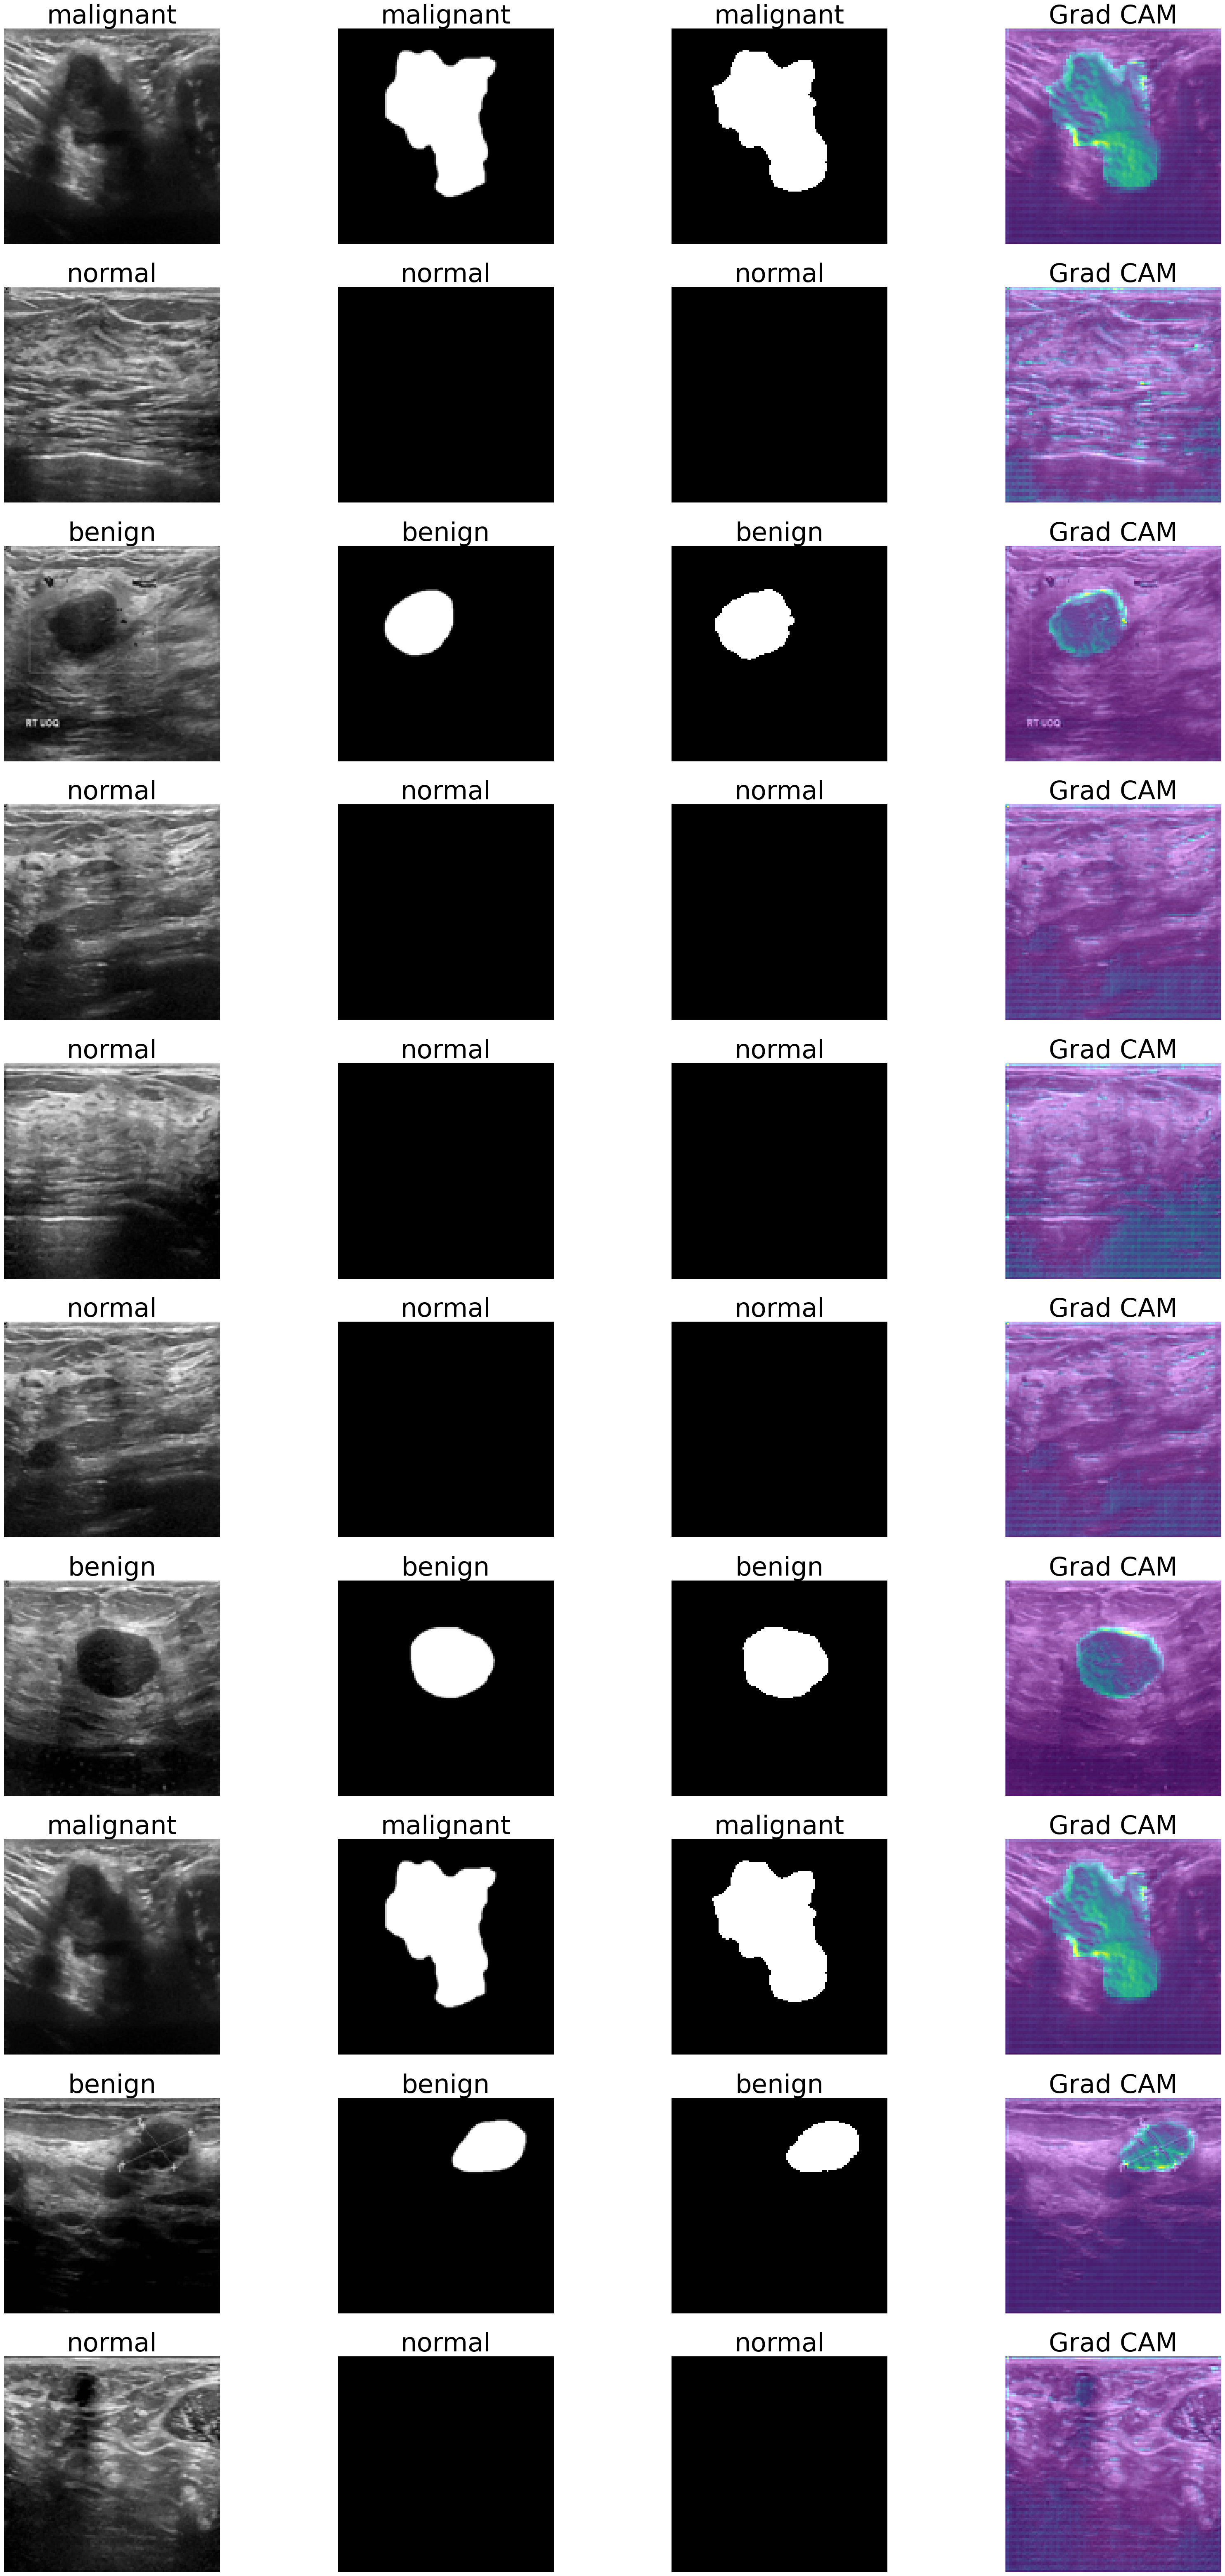

In [21]:
visualize_segmentation_and_classification(images,
                                          masks,
                                          labels,
                                          classification_model,
                                          attemption_residual_unet)

In [22]:
len(paths), len(np.argmax(labels, axis=1))

(780, 780)

In [23]:
info = ['benign', 'malignant', 'normal']
df_predictions = pd.DataFrame({"img": paths,
                               "y_true": np.argmax(labels, axis=1),
                               "y_pred": np.argmax(y_pred, axis=1),
                               "pred_probability": y_pred.max(axis=1),
                               "pred_prob>80%": y_pred.max(axis=1) > 0.8,
                               "y_true_classname": [info[np.argmax(i)] for i in labels],
                               "y_pred_classname": [info[np.argmax(i)] for i in y_pred]})

In [24]:
df_predictions.head()

img  y_true  y_pred  pred_probability  \
0  ../.data/benign/benign (428).png       0       0          0.999052   
1  ../.data/benign/benign (138).png       0       0          0.999752   
2   ../.data/benign/benign (17).png       0       0          1.000000   
3  ../.data/benign/benign (190).png       0       0          0.999998   
4  ../.data/benign/benign (210).png       0       0          0.999059   

   pred_prob>80% y_true_classname y_pred_classname  
0           True           benign           benign  
1           True           benign           benign  
2           True           benign           benign  
3           True           benign           benign  
4           True           benign           benign

In [25]:
df_wrong_predictions = df_predictions[df_predictions["y_true"] != df_predictions["y_pred"]] \
                                            .sort_values("pred_probability",
                                                          ascending=False)

In [26]:
the_most_fatal_mistakes = df_wrong_predictions[df_wrong_predictions['y_pred'] == 2]
the_most_fatal_mistakes

img  y_true  y_pred  pred_probability  \
436       ../.data/benign/benign (368).png       0       2          0.951306   
90         ../.data/benign/benign (65).png       0       2          0.903055   
636  ../.data/malignant/malignant (70).png       1       2          0.799034   
583  ../.data/malignant/malignant (62).png       1       2          0.707018   
268        ../.data/benign/benign (78).png       0       2          0.595142   
227       ../.data/benign/benign (201).png       0       2          0.594974   
305       ../.data/benign/benign (378).png       0       2          0.580533   

     pred_prob>80% y_true_classname y_pred_classname  
436           True           benign           normal  
90            True           benign           normal  
636          False        malignant           normal  
583          False        malignant           normal  
268          False           benign           normal  
227          False           benign           normal  
305          False           benign           normal

In [27]:
calculate_results(labels, y_pred)


{'accuracy': 97.43589743589743,
 'precision': 97.4574729853263,
 'recall': 97.43589743589743,
 'f1': 97.43593402563782,
 'MCC': 0.9563264173114717,
 'kappa': 0.9562483523017293}

In [28]:
y_pred_test = classification_model.predict(X_test_c)
calculate_results(y_test_c, y_pred_test)

3/3 [==============================] - 1s 225ms/step


{'accuracy': 89.74358974358975,
 'precision': 90.04605150946617,
 'recall': 89.74358974358975,
 'f1': 89.80145245205485,
 'MCC': 0.8302753098677147,
 'kappa': 0.8295547664572521}